# Lab 1 - Preparing the Data

## Imports and loading the data

In [23]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

titanic_df = pd.read_csv('titanic.csv', index_col='PassengerId')

Column 'Ticket' with ticket number is irrelevant to the task and can be omitted. Column name can be dropped as well, since it doesn't affect the survival chance. The function DatFrame.convert_dtypes() applies the right type to columns.

In [24]:
titanic_df.drop(columns=['Name', 'Ticket'], inplace=True)
titanic_df = titanic_df.convert_dtypes()
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    Int64  
 1   Pclass    891 non-null    Int64  
 2   Sex       891 non-null    string 
 3   Age       714 non-null    Float64
 4   SibSp     891 non-null    Int64  
 5   Parch     891 non-null    Int64  
 6   Fare      793 non-null    Float64
 7   Cabin     204 non-null    string 
 8   Embarked  889 non-null    string 
dtypes: Float64(2), Int64(4), string(3)
memory usage: 74.8 KB


## Cleaning the Na values

There are between 0-3 Na values in each row. There are no empty rows that can be deleted. The missing values are of categories: Age, Fare, Cabin and Embarked. The least Nas are in 'Embarked'- only 2, which is 0.22%. The most Na values are in 'Cabin'- 687, which makes 77.1%. Nans in 'Age' make 19.87% and in 'Fare' 11%.

In [25]:
titanic_df.isna().sum(axis=1).unique()
nan_values_count = titanic_df.isna().sum()
nan_values_count

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare         98
Cabin       687
Embarked      2
dtype: int64

In [26]:
def count_percentage(a, b):
 return round((a/b)*100,2)

(count_percentage(nan_values_count['Embarked'], titanic_df.shape[0]),
 count_percentage(nan_values_count['Cabin'], titanic_df.shape[0]),
 count_percentage(nan_values_count['Age'], titanic_df.shape[0]),
 count_percentage(nan_values_count['Fare'], titanic_df.shape[0]))


(np.float64(0.22), np.float64(77.1), np.float64(19.87), np.float64(11.0))

In [27]:
def plot_histogram(df, column, xlabel, interval):
    mean = np.mean(df[column])
    median = np.median(df[column])
    mode = df[column].mode()[0]

    plt.figure()
    plt.hist(df[column], bins=interval)
    plt.axvline(mean, color='r', label='mean')
    plt.axvline(median, color='b', label='median')
    plt.axvline(mode, color='g', label='mode')
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

### 'Embarked'
The Nas in categorical column 'Embarked' will be replaced with mode, because S is dominating and only 2 values need replacing.


In [28]:
titanic_df['Embarked'].value_counts()
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(value='S')

### 'Cabin'
The Nas in categorical column 'Cabin' will be replaced with a new category 'Unknown' since no value is dominating. Visualization would be useless because differences between every category are small, but value 'Unknown' is peaking high up - histogram would be just one peak.

In [29]:
titanic_df['Cabin'].value_counts()
titanic_df['Cabin'].isna().value_counts()
titanic_df['Cabin'] = titanic_df['Cabin'].fillna(value='Unknown')


### 'Age'
The numerical column 'Age' is of type float, but there are only 25 values with fractional part. Values like '0.42' or '0.67' make no sense. It should be of type integer, but I don't want to disrupt the data. The data distribution is asymmetrical, right sided, but similar to normal. After replacing Nans with median there is a significant peak in one bin, so another approach is taken. The missing data is replaced according to the existing distribution.

In [30]:
is_nan_series = titanic_df['Age'].isna()
is_integer_series = titanic_df['Age'].apply(float.is_integer)
is_nan_or_integer_series = is_nan_series | is_integer_series
is_nan_or_integer_series.value_counts()

Age
True     866
False     25
Name: count, dtype: int64

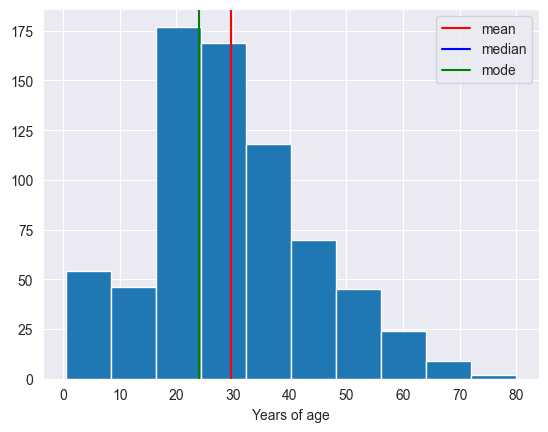

In [31]:
plot_histogram(titanic_df, 'Age', 'Years of age', 10)

In [32]:
def get_column_distribution(df, column):
    return df[column].value_counts(normalize=True)

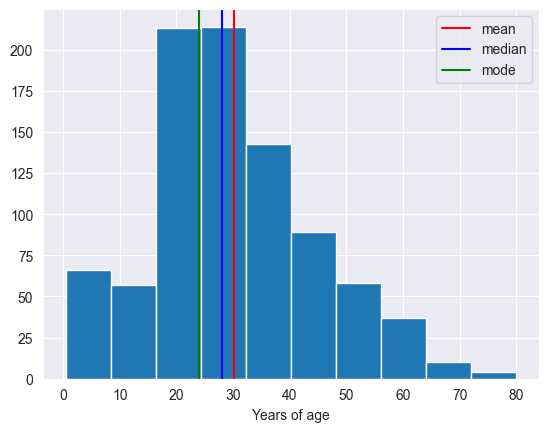

In [33]:
age_count_prob = get_column_distribution(titanic_df, 'Age')
age_values = age_count_prob.index
age_prob = age_count_prob.values
is_age_na_mask = titanic_df.Age.isna()
titanic_df.loc[is_age_na_mask, 'Age'] = np.random.choice(age_values,size=is_age_na_mask.sum(), p=age_prob)
plot_histogram(titanic_df, 'Age', 'Years of age', 10)

### 'Fare'
Numerical column 'Fare' of type float should be rounded to 2 decimal places, since it's a price. The data distribution is strongly asymmetrical so Na values will be replaced with median.

In [34]:
titanic_df['Fare'] = titanic_df['Fare'].apply(lambda x: round(x,2))

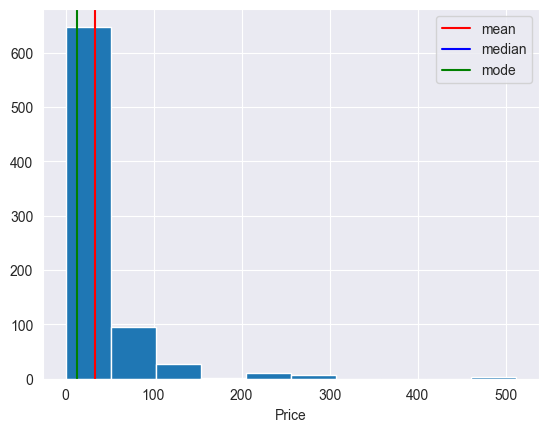

In [35]:
plot_histogram(titanic_df, 'Fare', 'Price', 10)

After clearing the Na values data distribution is really similar.

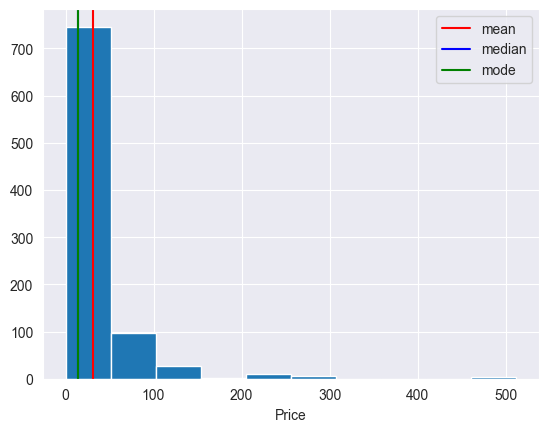

In [36]:
fare_median = titanic_df['Fare'].median()
titanic_df['Fare'] = titanic_df['Fare'].fillna(fare_median)
plot_histogram(titanic_df, 'Fare', 'Price', 10)

## Data Enrichment

### Cabin Column
As I checked on the internet Titanic had decks from A to G, and 'T' was the only passenger cabin on boat deck known to have been occupied. The first letter of cabin determined the deck. I could create a new category 'Deck' which could give useful input if it correlates to survival, but this would also create a lot of 'Unknown' values, so I decided it's best not to add it to the final DataFrame.

In [37]:
def cabin_to_deck(x):
    if x == "Unknown":
        return x
    elif 'A' in x:
        return 'A'
    elif 'B' in x:
        return 'B'
    elif 'C' in x:
        return 'C'
    elif 'D' in x:
        return "D"
    elif 'E' in x:
        return "E"
    elif 'F' in x:
        return "F"
    elif 'G' in x:
        return 'G'
    elif 'T' in x:
        return 'T'

deck_column = pd.Series(data=titanic_df['Cabin'].apply(cabin_to_deck), index=titanic_df.index, name='Deck')
pd.concat([titanic_df, deck_column], axis=1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.25,Unknown,S,Unknown
2,1,1,female,38.0,1,0,71.28,C85,C,C
3,1,3,female,26.0,0,0,7.92,Unknown,S,Unknown
4,1,1,female,35.0,1,0,53.10,C123,S,C
5,0,3,male,35.0,0,0,8.05,Unknown,S,Unknown
...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.00,Unknown,S,Unknown
888,1,1,female,19.0,0,0,30.00,B42,S,B
889,0,3,female,17.0,1,2,23.45,Unknown,S,Unknown


### Adult Column
Column stating if the passenger is an adult or not (under 18) is added using encoding: 0 -> no, 1 -> yes.

In [38]:
adult = pd.Series(data=titanic_df['Age'].copy(), index=titanic_df.index, name='Adult')
adult = adult.apply(lambda x: 1 if x >=18 else 0)
titanic_df = pd.concat([titanic_df, adult], axis=1)

### Total Family Column
Adding values from columns 'SibSp' and 'Parch' results in total amount of family the passenger has onboard.

In [39]:
total_family_series = titanic_df['SibSp'] + titanic_df['Parch']
total_family_series.name = 'TotalFamily'
titanic_df = pd.concat([titanic_df, total_family_series], axis=1)

After enriching data with two columns dataframe looks like this

In [40]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Adult,TotalFamily
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.25,Unknown,S,1,1
2,1,1,female,38.0,1,0,71.28,C85,C,1,1
3,1,3,female,26.0,0,0,7.92,Unknown,S,1,0
4,1,1,female,35.0,1,0,53.10,C123,S,1,1
5,0,3,male,35.0,0,0,8.05,Unknown,S,1,0
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.00,Unknown,S,1,0
888,1,1,female,19.0,0,0,30.00,B42,S,1,0
889,0,3,female,17.0,1,2,23.45,Unknown,S,0,3


## Heatmap
I decided it's best to visualize the heatmap here, before one hot encoding. It will have a smaller size. There is a positive correlation between survival and fare - the pricier the ticket the higher chance of survival. It corresponds to the negative correlation between survival and class - the lower the class (1st being the best and the most expensive) the higher survival rate. Anything else seems to have little to practically no effect on whether passenger made it alive. Strong correlatrion between 'Adult' and 'Age' - obviously. If passenger had family onboard it correlated to the higher price of a ticket.

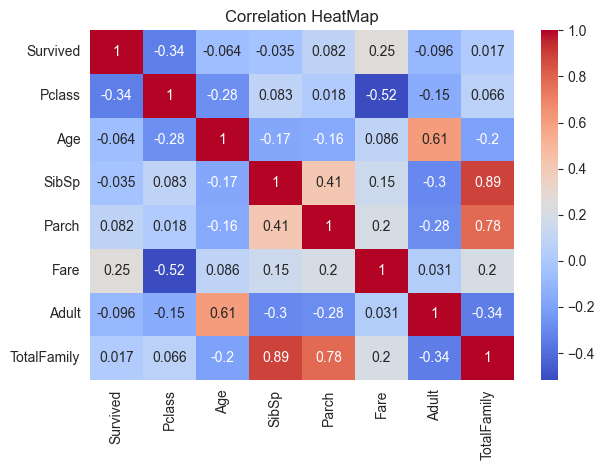

In [41]:
corr_matrix = titanic_df.corr(numeric_only=True)
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation HeatMap')
plt.tight_layout()
plt.show()

## Encoding categorical columns
## 'Sex' Column
Sex column encoding: 0 -> male, 1 -> female

In [42]:
titanic_df['Sex'] = titanic_df['Sex'].apply(lambda x: 0 if x == 'male' else 1)

### 'Cabin' Column
I have no idea which encoding should I use on 'Cabin'. It's a room number so it has no order and serves just as ID. There are 148 unique values (including 'Unknown') so with one hot encoding I would add 148 dimensions, it seems to be wrong. I will replace the 'Cabin' column with 'Deck' column, it will add fewer than 10 dimensions after one hot encoding (I need to do this because task is to encode every categorical value). There is just no other way, at least to my knowledge. There are 9 unique values now (including 'Unknown') and the loss of the number of the rooms seems insignificant. Maybe richer people had bigger apartments, but their numbers could differ from deck to deck and I don't see how this could be important for survival

In [43]:
len(titanic_df['Cabin'].unique())
titanic_df['Cabin'] = deck_column
titanic_df.rename(columns={'Cabin': 'Deck'}, inplace=True)
len(titanic_df['Deck'].unique())

9

In [44]:
titanic_df = pd.get_dummies(data=titanic_df, prefix='Deck', columns=['Deck'], dtype=np.int32)
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Adult,TotalFamily,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,S,1,1,0,0,0,0,0,0,0,0,1
2,1,1,1,38.0,1,0,71.28,C,1,1,0,0,1,0,0,0,0,0,0
3,1,3,1,26.0,0,0,7.92,S,1,0,0,0,0,0,0,0,0,0,1
4,1,1,1,35.0,1,0,53.10,S,1,1,0,0,1,0,0,0,0,0,0
5,0,3,0,35.0,0,0,8.05,S,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.00,S,1,0,0,0,0,0,0,0,0,0,1
888,1,1,1,19.0,0,0,30.00,S,1,0,0,1,0,0,0,0,0,0,0
889,0,3,1,17.0,1,2,23.45,S,0,3,0,0,0,0,0,0,0,0,1


### 'Embarked' Column
This column will be also one hot encoded because there is no order in the categories (no port is less than/more than others) and other encodings could mislead the model.

In [45]:
titanic_df = pd.get_dummies(data=titanic_df, prefix='Embarked', columns=['Embarked'], dtype=np.int32)
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Adult,TotalFamily,Deck_A,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,1,1,0,...,0,0,0,0,0,0,1,0,0,1
2,1,1,1,38.0,1,0,71.28,1,1,0,...,1,0,0,0,0,0,0,1,0,0
3,1,3,1,26.0,0,0,7.92,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,1,1,35.0,1,0,53.10,1,1,0,...,1,0,0,0,0,0,0,0,0,1
5,0,3,0,35.0,0,0,8.05,1,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.00,1,0,0,...,0,0,0,0,0,0,1,0,0,1
888,1,1,1,19.0,0,0,30.00,1,0,0,...,0,0,0,0,0,0,0,0,0,1
889,0,3,1,17.0,1,2,23.45,0,3,0,...,0,0,0,0,0,0,1,0,0,1


Now our data is free of Nans and encoded for the model. We can come to conclusions and visualise the data.

### Outliers
For detecting outliers I will use boxplot. For 'Age' the only outliers are above age circa 65.

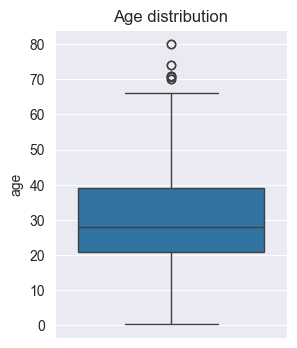

In [46]:
def plot_boxplot(df, column, ylabel, title):
    plt.figure(figsize=(3,4))
    sns.boxplot(data=df[column])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_boxplot(titanic_df, 'Age', 'age', 'Age distribution')

Other column that we can detect outliers for is 'Fare'. It looks like one person paid twice as much as the other person who paid second most. This can be an error which we can investigate further.

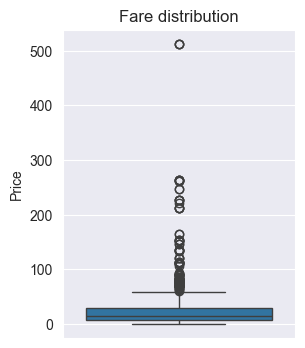

In [47]:
plot_boxplot(titanic_df, 'Fare', 'Price', 'Fare distribution')

The person who paid this price is a woman in her 30s, in 1st class with no family. The 1st class is appropriate to the high price, but other passengers didn't pay as much. I found on the internet that the most expensive suites on titanic were on decks B and C but sadly there's no 'Deck' data for her.

In [48]:
titanic_df.loc[titanic_df['Fare'].idxmax()]

Survived           1.0
Pclass             1.0
Sex                1.0
Age               35.0
SibSp              0.0
Parch              0.0
Fare            512.33
Adult              1.0
TotalFamily        0.0
Deck_A             0.0
Deck_B             0.0
Deck_C             0.0
Deck_D             0.0
Deck_E             0.0
Deck_F             0.0
Deck_G             0.0
Deck_T             0.0
Deck_Unknown       1.0
Embarked_C         1.0
Embarked_Q         0.0
Embarked_S         0.0
Name: 259, dtype: Float64

## More Data Visualisation
### How many people survived based on their Pclass?

As we can see, the most deaths are in the poorest class and there is significant difference in the number of survival and deaths. In class 1 and 2 numbers are split closer to 50:50. The only class where more people survived than died is the first class. I also made the split percentage bar chart to see clearer the ratios of deaths and lives in all the classes. As we see the lower the class, the likeliness of survival drops - rich people had priority.

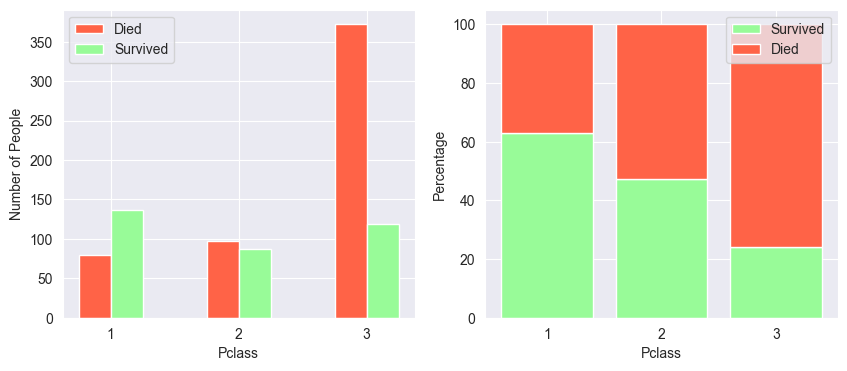

In [49]:
pclass_survived_count = titanic_df.groupby(['Survived', 'Pclass']).size()
cats = np.sort(titanic_df['Pclass'].unique()) # MultiIndexes

def pclass_survival_percentage(series, pclass):
    survived_percentage = series.loc[(1, pclass)] / (series.loc[(0, pclass)] + series.loc[(1, pclass)]) * 100
    return survived_percentage

barWidth = 0.25
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bar1 = np.arange(len(cats))
bar2 = [x + barWidth for x in bar1]
plt.bar(bar1, pclass_survived_count.loc[:(0,3)], width=barWidth, color = 'tomato')
plt.bar(bar2, pclass_survived_count.loc[(1,1):], width=barWidth, color = 'palegreen')
plt.xlabel('Pclass')
plt.xticks((bar1+bar2)/2, cats)
plt.ylabel('Number of People')
plt.legend(['Died', 'Survived'])

plt.subplot(1,2,2)
x =['1', '2', '3']
y1 = []
for i in range(1, 4):
    y1.append(pclass_survival_percentage(pclass_survived_count, i))
y2 = [100 - x for x in y1]
plt.bar(x, y1, color = 'palegreen')
plt.bar(x, y2, bottom = y1, color = 'tomato')
plt.xlabel('Pclass')
plt.ylabel('Percentage')
plt.legend(['Survived', 'Died'])
plt.show()

We can also check Survival based on Sex and being a child (less than 18). As we can see women had much higher probability to live, while men to die. I wonder if being a woman, child and in 1st class guaranteed survival. I also divided children in 3 age subcategories: toddler, child and teenager. I think each group has different survival skills - toddlers have non and easily drown, children would be sent first to rescue boats and for example male teenagers could be considered adults and sent to rescue boats last.

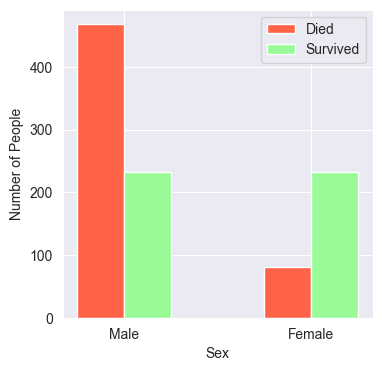

In [50]:
sex_survived_count = titanic_df.groupby(['Survived', 'Sex']).size()
cats = np.sort(titanic_df['Sex'].unique())

plt.figure(figsize=(4,4))
bar1 = np.arange(len(cats))
bar2 = [x + barWidth for x in bar1]
plt.bar(bar1, sex_survived_count.loc[:(0,1)], width=barWidth, color = 'tomato')
plt.bar(bar2, sex_survived_count.loc[(1,1):], width=barWidth, color = 'palegreen')
plt.xlabel('Sex')
plt.xticks((bar1+bar2)/2, ['Male', 'Female'])
plt.ylabel('Number of People')
plt.legend(['Died', 'Survived'])


In [51]:
mask = titanic_df['Adult'] == 0
child_df = titanic_df.loc[mask]
def age_to_subgroup(x):
    if x <3:
        return 'Infant'
    elif x <14:
        return 'Child'
    else:
        return 'Teenager'

age_subgroup = pd.Series(data=child_df['Age'].apply(age_to_subgroup), index=child_df.index, name='AgeSubgroup')
child_df = pd.concat([child_df, age_subgroup], axis=1)

As i suspected, children were the biggest subgroup that survived. Teenagers were the group that has the most deaths.

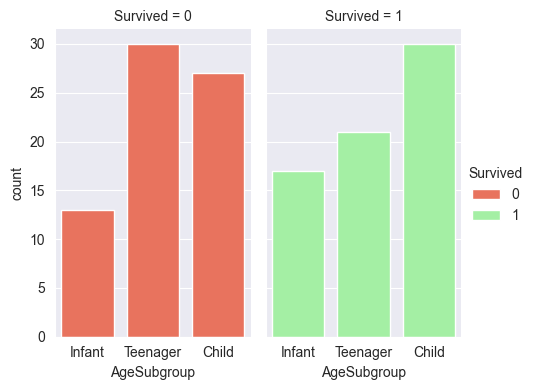

In [52]:
g = sns.catplot(data = child_df, x = 'AgeSubgroup', col='Survived', hue = 'Survived', kind = "count", palette = ['tomato', 'palegreen'], height=4, aspect=.6,)

We can see that most of  passengers were there alone, without family.

(array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   0.,   7.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5]),
 <BarContainer object of 11 artists>)

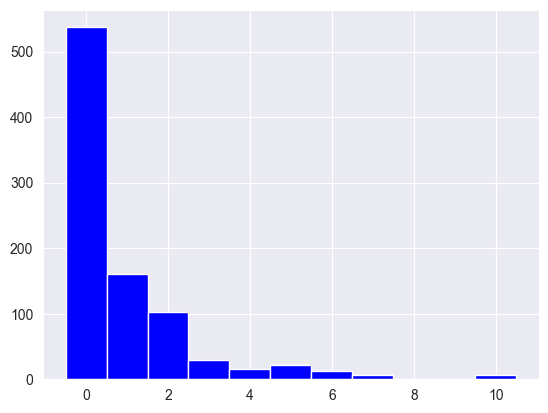

In [53]:
d = np.diff(np.unique(titanic_df['TotalFamily'])).min()
left_of_first_bin = titanic_df['TotalFamily'].min() - float(d)/2
right_of_last_bin = titanic_df['TotalFamily'].max() + float(d)/2
plt.hist(titanic_df['TotalFamily'],np.arange(left_of_first_bin, right_of_last_bin + d, d), color='blue')

# Lab 2